### trade based simulation

# data import using yfinance

## 라이브러리 임포트

In [2]:
!pip install yfinance
!pip install pandas-datareader

     |████████████████████████████████| 6.4 MB 8.1 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [3]:
import math
import time
from datetime import datetime
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_datareader as pdr
from collections import deque

In [57]:
current_date = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

## 데이터 임포트

In [5]:
tickers = ["SPY", "QQQ", "GLD", "LQD", "EEM"]
risk_free_asset = "TB3MS"

In [6]:
divs = []
for ticker in tickers:
  div = yf.Ticker(ticker).dividends
  div.index = pd.to_datetime(div.index).strftime('%Y-%m')
  if not div.index.is_unique:
    div = div.groupby(div.index).sum()
  divs.append(div)

In [7]:
dividends_df = pd.concat(divs, axis=1)
dividends_df.columns = [["Dividend"] * len(tickers), tickers]
dividends_df.index.name = "Date"
dividends_df.sort_index(inplace=True)

In [8]:
dividends_df

Dividend                         
             SPY    QQQ GLD    LQD    EEM
Date                                     
1993-03    0.213    NaN NaN    NaN    NaN
1993-06    0.318    NaN NaN    NaN    NaN
1993-09    0.286    NaN NaN    NaN    NaN
1993-12    0.317    NaN NaN    NaN    NaN
1994-03    0.271    NaN NaN    NaN    NaN
...          ...    ...  ..    ...    ...
2021-09    1.428  0.414 NaN  0.234    NaN
2021-10      NaN    NaN NaN  0.255    NaN
2021-11      NaN    NaN NaN  0.262    NaN
2021-12    1.633  0.491 NaN  0.495  0.733
2022-02      NaN    NaN NaN  0.242    NaN

[251 rows x 5 columns]

In [9]:
tickers_df = yf.download(" ".join(tickers), period='max', interval='1mo')

[*********************100%***********************]  5 of 5 completed


In [10]:
tickers_df.index = pd.to_datetime(tickers_df.index).strftime('%Y-%m')

In [11]:
opens_df = tickers_df["Open"]
closes_df = tickers_df["Close"]
# tickers_df.drop(columns=["Adj Close", "High", "Low", "Open", "Volume"], inplace=True)
# tickers_df.dropna(how="all", inplace=True)

In [12]:
closes_df

,EEM,GLD,LQD,QQQ,SPY
Date,,,,,
1993-02,NaN,NaN,NaN,NaN,44.406250
1993-03,NaN,NaN,NaN,NaN,45.187500
1993-03,NaN,NaN,NaN,NaN,NaN
1993-04,NaN,NaN,NaN,NaN,44.031250
1993-05,NaN,NaN,NaN,NaN,45.218750
...,...,...,...,...,...
2021-12,NaN,NaN,NaN,NaN,NaN
2021-12,NaN,NaN,NaN,NaN,NaN
2022-01,48.840000,168.089996,127.760002,363.049988,449.910004


In [13]:
if not closes_df.index.is_unique:
    closes_df = closes_df.groupby(closes_df.index).last()

In [14]:
tb3ms_df = pdr.DataReader(risk_free_asset, "fred", closes_df.index[0], closes_df.index[-1] )
tb3ms_df["RoR12"] = tb3ms_df[risk_free_asset].map(lambda x: x / 100)
tb3ms_df["CRoR"] = (1 + tb3ms_df["RoR12"] / 12).cumprod()
tb3ms_df.index = pd.to_datetime(tb3ms_df.index).strftime('%Y-%m')

In [15]:
tb3ms_df

,TB3MS,RoR12,CRoR
DATE,,,
1993-02,2.93,0.0293,1.002442
1993-03,2.95,0.0295,1.004906
1993-04,2.87,0.0287,1.007309
1993-05,2.96,0.0296,1.009794
1993-06,3.07,0.0307,1.012377
...,...,...,...
2021-09,0.04,0.0004,1.912639
2021-10,0.05,0.0005,1.912718
2021-11,0.05,0.0005,1.912798


In [16]:
closes_df[risk_free_asset] = tb3ms_df["CRoR"]

In [17]:
closes_df.drop(closes_df.tail(1).index, inplace=True)

In [18]:
closes_df

,EEM,GLD,LQD,QQQ,SPY,TB3MS
Date,,,,,,
1993-02,NaN,NaN,NaN,NaN,44.406250,1.002442
1993-03,NaN,NaN,NaN,NaN,45.187500,1.004906
1993-04,NaN,NaN,NaN,NaN,44.031250,1.007309
1993-05,NaN,NaN,NaN,NaN,45.218750,1.009794
1993-06,NaN,NaN,NaN,NaN,45.062500,1.012377
...,...,...,...,...,...,...
2021-09,50.380001,164.220001,133.029999,357.959991,429.140015,1.912639
2021-10,50.919998,166.649994,133.479996,386.109985,459.250000,1.912718
2021-11,48.840000,165.500000,133.059998,393.820007,455.559998,1.912798


# calculate ror and find winners

In [19]:
exclude_period, look_back = 3, 12

In [20]:
ror_df = closes_df.apply(lambda x: round((x.shift(exclude_period) - x.shift(look_back)) / x.shift(look_back), 4), axis=0)

In [21]:
ror_df

,EEM,GLD,LQD,QQQ,SPY,TB3MS
Date,,,,,,
1993-02,NaN,NaN,NaN,NaN,NaN,NaN
1993-03,NaN,NaN,NaN,NaN,NaN,NaN
1993-04,NaN,NaN,NaN,NaN,NaN,NaN
1993-05,NaN,NaN,NaN,NaN,NaN,NaN
1993-06,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2021-09,0.2509,-0.0649,-0.0026,0.2757,0.2782,0.0004
2021-10,0.1541,-0.0362,0.0170,0.3534,0.3429,0.0004
2021-11,0.0755,0.0181,-0.0230,0.2681,0.2472,0.0004


In [22]:
winners = ror_df.idxmax(axis=1)

In [23]:
winners[:look_back] = risk_free_asset

In [24]:
winners = winners.to_numpy()

In [25]:
winners

array(['TB3MS', 'TB3MS', 'TB3MS', 'TB3MS', 'TB3MS', 'TB3MS', 'TB3MS',
       'TB3MS', 'TB3MS', 'TB3MS', 'TB3MS', 'TB3MS', 'SPY', 'SPY', 'SPY',
       'SPY', 'TB3MS', 'TB3MS', 'TB3MS', 'TB3MS', 'TB3MS', 'SPY', 'TB3MS',
       'TB3MS', 'TB3MS', 'TB3MS', 'SPY', 'SPY', 'SPY', 'SPY', 'SPY',
       'SPY', 'SPY', 'SPY', 'SPY', 'SPY', 'SPY', 'SPY', 'SPY', 'SPY',
       'SPY', 'SPY', 'SPY', 'SPY', 'SPY', 'SPY', 'SPY', 'SPY', 'SPY',
       'SPY', 'SPY', 'SPY', 'SPY', 'SPY', 'SPY', 'SPY', 'SPY', 'SPY',
       'SPY', 'SPY', 'SPY', 'SPY', 'SPY', 'SPY', 'SPY', 'SPY', 'SPY',
       'SPY', 'SPY', 'TB3MS', 'SPY', 'SPY', 'SPY', 'SPY', 'SPY', 'SPY',
       'SPY', 'SPY', 'SPY', 'SPY', 'SPY', 'SPY', 'SPY', 'SPY', 'SPY',
       'SPY', 'QQQ', 'QQQ', 'QQQ', 'QQQ', 'QQQ', 'QQQ', 'QQQ', 'QQQ',
       'TB3MS', 'TB3MS', 'TB3MS', 'TB3MS', 'TB3MS', 'TB3MS', 'TB3MS',
       'TB3MS', 'TB3MS', 'TB3MS', 'TB3MS', 'TB3MS', 'TB3MS', 'TB3MS',
       'TB3MS', 'TB3MS', 'TB3MS', 'TB3MS', 'TB3MS', 'TB3MS', 'TB3MS',
       'TB3

In [26]:
masking = np.roll(winners, 1) != winners

In [27]:
buy_tickers = winners[masking]

In [28]:
buy_tickers

array(['TB3MS', 'SPY', 'TB3MS', 'SPY', 'TB3MS', 'SPY', 'TB3MS', 'SPY',
       'QQQ', 'TB3MS', 'QQQ', 'EEM', 'SPY', 'EEM', 'GLD', 'SPY', 'GLD',
       'EEM', 'SPY', 'EEM', 'GLD', 'TB3MS', 'GLD', 'TB3MS', 'GLD', 'LQD',
       'EEM', 'QQQ', 'GLD', 'QQQ', 'GLD', 'QQQ', 'GLD', 'QQQ', 'SPY',
       'LQD', 'SPY', 'QQQ', 'TB3MS', 'QQQ', 'TB3MS', 'GLD', 'EEM', 'SPY',
       'QQQ', 'EEM', 'QQQ', 'EEM', 'QQQ', 'TB3MS', 'QQQ', 'SPY', 'QQQ',
       'GLD', 'QQQ', 'GLD', 'QQQ', 'EEM', 'SPY', 'EEM', 'SPY', 'QQQ',
       'SPY'], dtype=object)

In [29]:
buy_indices = np.where(masking)[0]

In [30]:
buy_indices, len(buy_indices)

(array([  0,  12,  16,  21,  22,  26,  69,  70,  86,  94, 125, 135, 140,
        141, 161, 167, 168, 169, 170, 171, 182, 191, 194, 196, 198, 199,
        200, 207, 210, 218, 221, 222, 224, 231, 239, 240, 242, 250, 273,
        275, 278, 279, 287, 289, 290, 297, 303, 304, 305, 311, 314, 315,
        316, 318, 322, 326, 330, 338, 341, 342, 343, 344, 346]), 63)

# transaction history (accessing df)

In [31]:
stamp = time.time()
holdings = deque([])
transactions = []
for ticker, index in zip(buy_tickers, buy_indices):
  date_ = closes_df.index[index]
  price_ = closes_df[ticker][index]
  new_buy = {"ticker": ticker, "buy_date": date_, "buy_price": price_}
  if len(holdings):
    # pop existing one
    new_sell = holdings.popleft()
    new_sell["sell_date"] = date_
    new_sell["sell_price"] = closes_df[new_sell["ticker"]][index]
    new_sell["ror"] = (new_sell["sell_price"] - new_sell["buy_price"]) / new_sell["buy_price"] + 1
    transactions.append(new_sell)
  # add new ticker
  holdings.append(new_buy)
print(time.time()-stamp)

0.00257110595703125


In [32]:
len(transactions), np.prod(list(map(lambda x: x["ror"], transactions)))

(62, 17.656100336254294)

# transactions history (itertuples)

In [33]:
stamp = time.time()
holdings = deque([])
transactions = []
for row, ticker in zip(closes_df[masking].itertuples(), buy_tickers):
  new_buy = {"ticker": ticker, "buy_date": row.Index, "buy_price": getattr(row, ticker)}
  if len(holdings):
    # pop existing one
    new_sell = holdings.popleft()
    new_sell["sell_date"] = row.Index
    new_sell["sell_price"] = getattr(row, new_sell["ticker"])
    new_sell["ror"] = (new_sell["sell_price"] - new_sell["buy_price"]) / new_sell["buy_price"] + 1
    transactions.append(new_sell)
  # add new ticker
  holdings.append(new_buy)
print(time.time()-stamp)

0.0024394989013671875


In [34]:
len(transactions), np.prod(list(map(lambda x: x["ror"], transactions)))

(62, 17.656100336254294)

In [35]:
# transactions

In [36]:
holding = holdings.pop()
holding["up_to_date"] = closes_df.index[-1]
holding["current_price"] = closes_df[holding["ticker"]][-1]
holding["ror"] = (holding["current_price"] - holding["buy_price"]) / holding["buy_price"] + 1
transactions.append(holding)

In [37]:
# transactions

In [38]:
len(transactions), np.prod(list(map(lambda x: x["ror"], transactions)))

(63, 16.724895380359744)

# normalized closes

In [39]:
mrr_df = closes_df.apply(lambda x: round((x.shift(-1) - x) / x, 6) + 1, axis=0)

In [40]:
mrr_df.drop(mrr_df.tail(1).index, inplace=True)

In [41]:
mrr_df

,EEM,GLD,LQD,QQQ,SPY,TB3MS
Date,,,,,,
1993-02,NaN,NaN,NaN,NaN,1.017593,1.002458
1993-03,NaN,NaN,NaN,NaN,0.974412,1.002392
1993-04,NaN,NaN,NaN,NaN,1.026969,1.002467
1993-05,NaN,NaN,NaN,NaN,0.996545,1.002558
1993-06,NaN,NaN,NaN,NaN,0.995146,1.002533
...,...,...,...,...,...,...
2021-08,0.961267,0.967765,0.983222,0.942124,0.950350,1.000033
2021-09,1.010718,1.014797,1.003383,1.078640,1.070164,1.000042
2021-10,0.959152,0.993099,0.996853,1.019968,0.991965,1.000042


In [42]:
idx, cols = pd.factorize(winners[:-1])
winner_mrr = mrr_df.reindex(cols, axis=1).to_numpy()[np.arange(len(idx)), idx]

In [46]:
accum_df = mrr_df.apply(lambda x: x.cumprod())

In [47]:
accum_df["RELMOM"] = winner_mrr.cumprod()

In [48]:
accum_df

,EEM,GLD,LQD,QQQ,SPY,TB3MS,RELMOM
Date,,,,,,,
1993-02,NaN,NaN,NaN,NaN,1.017593,1.002458,1.002458
1993-03,NaN,NaN,NaN,NaN,0.991555,1.004856,1.004856
1993-04,NaN,NaN,NaN,NaN,1.018296,1.007335,1.007335
1993-05,NaN,NaN,NaN,NaN,1.014778,1.009912,1.009912
1993-06,NaN,NaN,NaN,NaN,1.009852,1.012470,1.012470
...,...,...,...,...,...,...,...
2021-08,3.940402,3.749325,1.258560,6.663640,9.663905,1.907985,16.011718
2021-09,3.982635,3.804804,1.262817,7.187668,10.341964,1.908065,17.135164
2021-10,3.819952,3.778547,1.258843,7.331192,10.258866,1.908145,17.477319


In [49]:
accum_best = accum_df.iloc[-1].max()

In [55]:
ceiling = (accum_best // 5 + 1) * 5 

In [65]:
start_month = int(accum_df.index[0].split("-")[1])

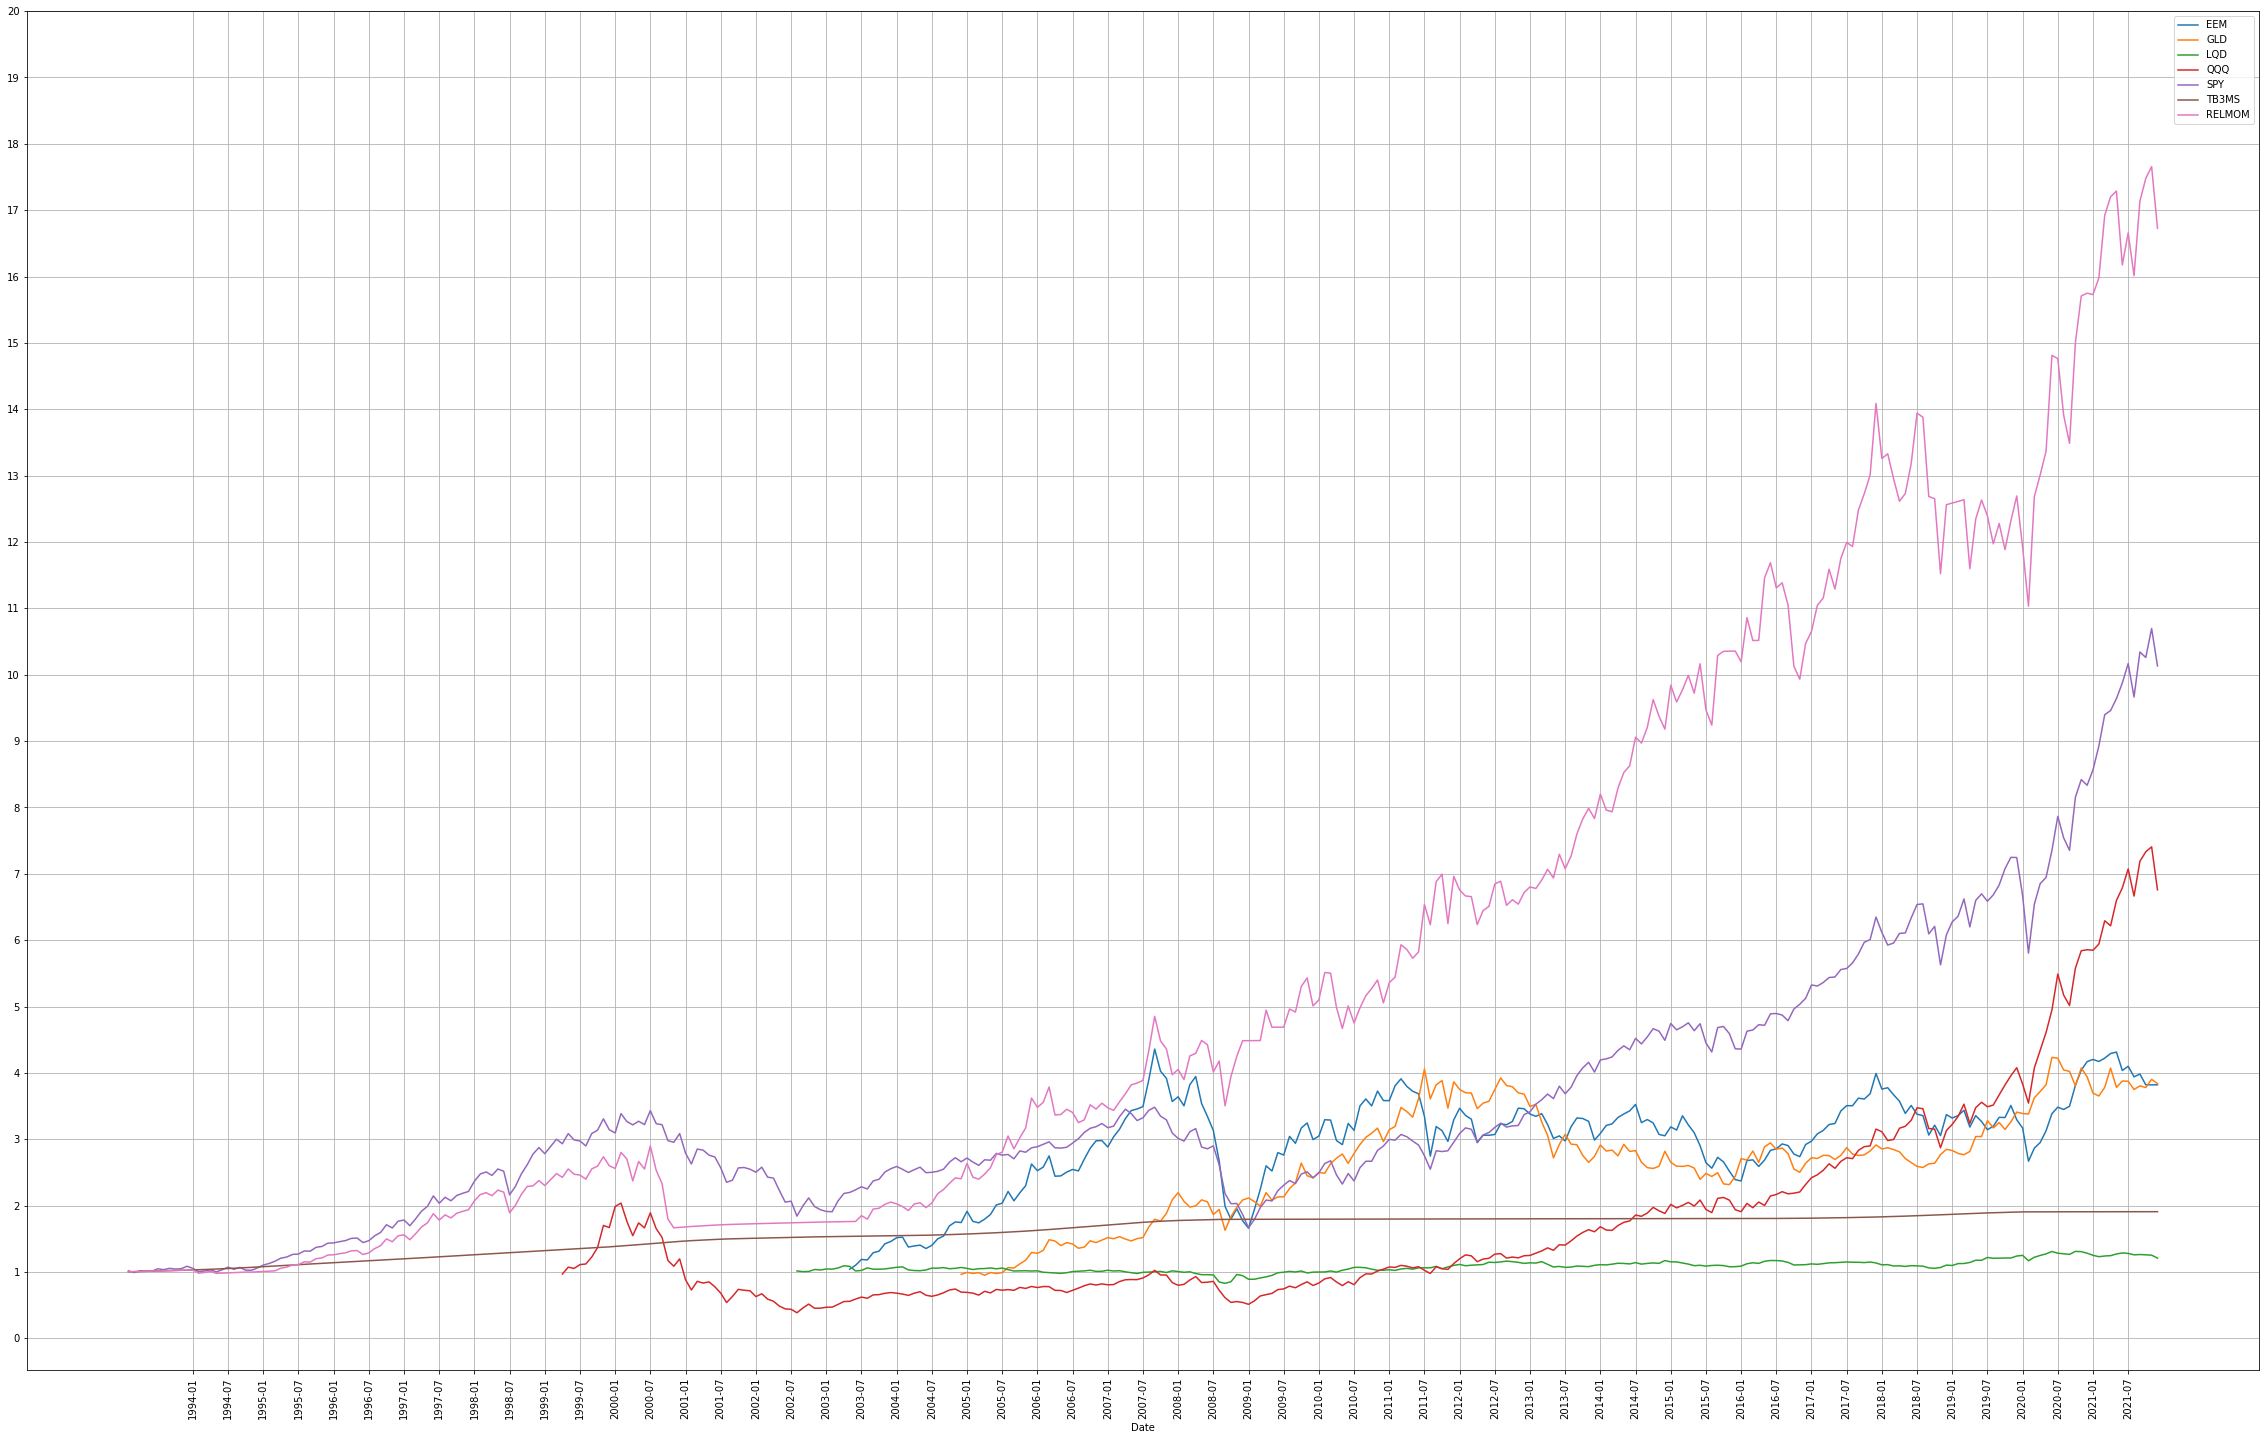

In [72]:
chart = accum_df.plot.line(grid=True, figsize=(40,25), xticks=np.arange((13 - start_month) % 12, len(accum_df.index), 6), yticks=np.arange(0, ceiling + 1, ceiling / 20))
chart.tick_params(axis="x", rotation=90)
# chart.figure.savefig(f'/content/drive/MyDrive/momentum-strategies/absolute_momentum/{current_date}_returns_accum.jpg')